GRAPH EMBEDDINGS

Read graph, display degree distribution and perform normality test

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the graphs

In [3]:
# --- Step 1: Load the graphs ---
G = nx.read_gexf('monthly_graphs/graph_2018_month01.gexf')
#G = nx.read_gexf('2018_graph/graph_2018.gexf')

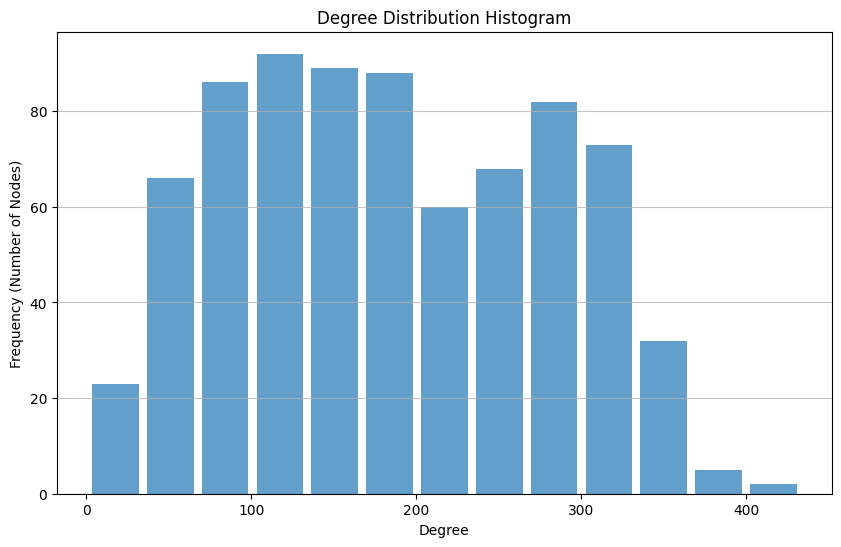

In [7]:
# --- Step 2: Calculate Node Degrees ---
degrees = [G.degree(n) for n in G.nodes()]

# --- Step 3: Plot the Histogram ---
plt.figure(figsize=(10, 6))
# The `bins` parameter can be an integer or 'auto' to let matplotlib decide
plt.hist(degrees, bins='auto', alpha=0.7, rwidth=0.85)

plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency (Number of Nodes)")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [8]:
# --- Step 1: Calculate local assortativity (from previous code) ---
def local_degree_assortativity(G):
    local_assort = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 0:
            local_assort[node] = np.nan
            continue
        node_degree = G.degree(node)
        avg_diff = np.mean([abs(node_degree - G.degree(n)) for n in neighbors])
        local_assort[node] = avg_diff
    return local_assort

# Calculate local assortativity
local_assort_dict = local_degree_assortativity(G)

# --- Step 2: Prepare data for Shapiro-Wilk test ---
# Convert to list and remove NaN values
assort_values = [v for v in local_assort_dict.values() if not np.isnan(v)]

print(f"Number of nodes with valid assortativity: {len(assort_values)}")
 

Number of nodes with valid assortativity: 766


Shapiro-Wilk Test Statistic: 0.7792588336032659
P-value: 6.993904061801433e-31
The data does not appear to be normally distributed (reject H0).


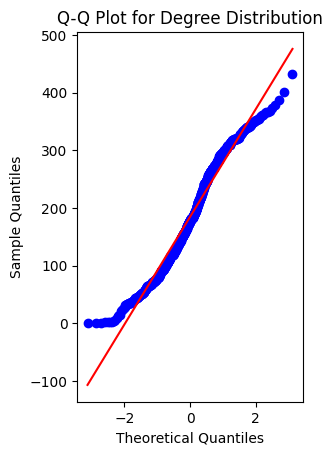

In [ ]:
# --- Step 4: Perform Normality Testing and Plot ---
# Perform the Shapiro-Wilk test for normality on the degrees
if len(degrees) > 2:
    shapiro_statistic, shapiro_p_value = stats.shapiro(degrees)
    print(f"Shapiro-Wilk Test Statistic: {shapiro_statistic}")
    print(f"P-value: {shapiro_p_value}")
    if shapiro_p_value > 0.05:
        print("The data appears to be normally distributed (fail to reject H0).")
    else:
        print("The data does not appear to be normally distributed (reject H0).")
else:
    print("Not enough data points to perform Shapiro-Wilk test.")


# Generate and display the Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(degrees, dist="norm", plot=plt)
plt.title("Q-Q Plot for Degree Distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

# Show the plots
plt.show()

Create vector representation of node using node2vec

In [232]:
# --- Step 2: Generate Embeddings with Node2Vec ---

# The Node2Vec constructor takes the graph, dimensions of the embeddings,
# and parameters for the random walks.
# walk_length: How many nodes are in each random walk.
# num_walks: How many random walks to start from each node.
# workers: Number of parallel threads to use.
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the model to generate the embeddings.
# This may take a few minutes depending on the size of your graph.
# 'window' is the context size for the underlying Word2Vec model.
# 'min_count=1' ensures all nodes are embedded.
model = node2vec.fit(window=10, min_count=1, batch_words=4)
print("Node2Vec model training complete.")

# The embeddings are stored in a KeyedVectors object (part of gensim)
# We can access the vector for a specific node like this:
# vector_for_node_A = model.wv['station_id_A']

# Get all node names (station IDs) and their corresponding vectors
nodes = list(G.nodes())
embedding_vectors = [model.wv[node] for node in nodes]


Computing transition probabilities: 100%|██████████| 849/849 [09:41<00:00,  1.46it/s]


Node2Vec model training complete.


Elbow method for k-means

Calculating inertia for k values from 5 to 25...
  k=5, Inertia=1773.27
  k=10, Inertia=1317.98
  k=15, Inertia=1097.27
  k=20, Inertia=975.46
  k=25, Inertia=874.51
  k=30, Inertia=825.86
  k=35, Inertia=771.66
  k=40, Inertia=738.17
  k=45, Inertia=700.88
  k=50, Inertia=677.89
  k=55, Inertia=643.91
  k=60, Inertia=624.84
  k=65, Inertia=607.53
  k=70, Inertia=584.38
  k=75, Inertia=570.70
  k=80, Inertia=552.78


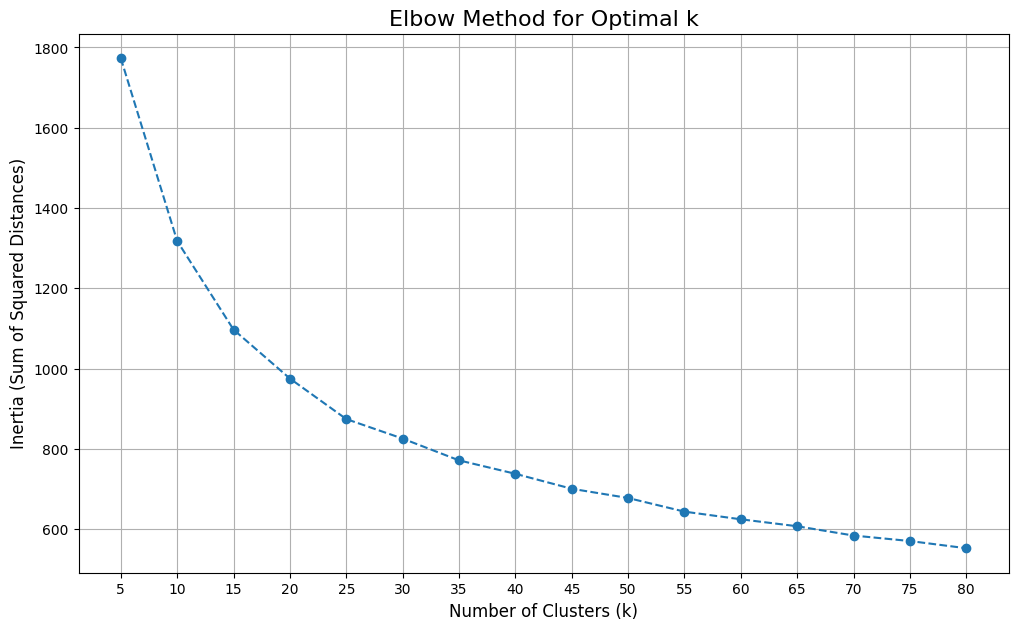

In [233]:
# --- Step 1: Run K-Means for a Range of k Values ---

# We will test k values from 2 up to 15
k_range = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]
inertias = []

print("Calculating inertia for k values from 5 to 25...")

for k in k_range:
    # Initialize and fit the K-Means model for the current k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embedding_vectors)
    
    # Append the inertia (sum of squared distances) to our list
    inertias.append(kmeans.inertia_)
    print(f"  k={k}, Inertia={kmeans.inertia_:.2f}")


# --- Step 2: Plot the Elbow Curve ---

plt.figure(figsize=(12, 7))
plt.plot(k_range, inertias, marker='o', linestyle='--')

plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

Clustering complete.


C:\Users\billy\AppData\Local\Temp\ipykernel_2200\1308578365.py:19: UserWarning: Mismatched number of handles and labels: len(handles) = 9 len(labels) = 25
  plt.legend(handles=scatter.legend_elements()[0], labels=range(num_clusters))


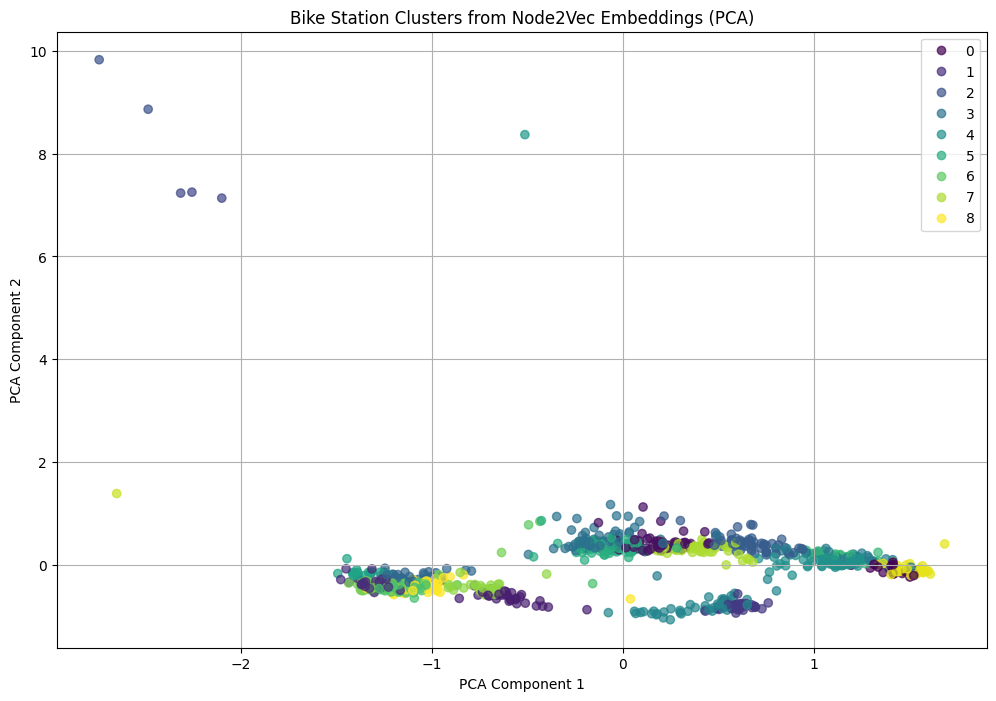


--- Analysis of Station Clusters ---

Cluster 0 contains 23 stations.
Sample stations: ['3318.0', '3351.0', '3425.0', '3379.0', '3496.0']

Cluster 1 contains 66 stations.
Sample stations: ['435.0', '509.0', '494.0', '3258.0', '426.0']

Cluster 2 contains 34 stations.
Sample stations: ['460.0', '3093.0', '2002.0', '3118.0', '3016.0']

Cluster 3 contains 31 stations.
Sample stations: ['3569.0', '3584.0', '3562.0', '3579.0', '3571.0']

Cluster 4 contains 43 stations.
Sample stations: ['3526.0', '3532.0', '3530.0', '3517.0', '3524.0']

Cluster 5 contains 3 stations.
Sample stations: ['3254.0', '3479.0', '3182.0']

Cluster 6 contains 2 stations.
Sample stations: ['3036.0', '3488.0']

Cluster 7 contains 59 stations.
Sample stations: ['514.0', '477.0', '478.0', '529.0', '490.0']

Cluster 8 contains 49 stations.
Sample stations: ['232.0', '217.0', '398.0', '321.0', '391.0']

Cluster 9 contains 62 stations.
Sample stations: ['363.0', '3002.0', '3256.0', '2008.0', '327.0']

Cluster 10 contains 

In [ ]:
# --- Step 3: Analyze the Embeddings with Clustering ---

# 1. Cluster the embeddings using K-Means to find groups of similar stations
num_clusters = 25
kmeans = KMeans(n_clusters=num_clusters, random_state=1, n_init=10)
clusters = kmeans.fit_predict(embedding_vectors)
print("Clustering complete.")

# 2. Use PCA to reduce the embedding dimensions for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embedding_vectors)

# 3. Visualize the clustered embeddings
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Bike Station Clusters from Node2Vec Embeddings (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(num_clusters))
plt.grid(True)
plt.show()


# --- Step 4: Inspect the Clusters ---
results = pd.DataFrame({'station_id': nodes, 'cluster': clusters})

print("\n--- Analysis of Station Clusters ---")
for i in range(num_clusters):
    cluster_nodes = results[results['cluster'] == i]['station_id'].tolist()
    print(f"\nCluster {i} contains {len(cluster_nodes)} stations.")
    print(f"Sample stations: {cluster_nodes[:5]}") # Uncomment to view some station IDs in the cluster


Calculate traditional centrality scores and find highest average scores

In [250]:
# --- Step 1: Calculate Centrality Scores for Every Node ---

# Degree Centrality: Measures the number of connections a node has.
degree_centrality = nx.degree_centrality(G)

# Betweenness Centrality: Measures how often a node lies on the shortest path between other nodes.
# This is a great indicator of a "bridge" node. It's computationally intensive.
betweenness_centrality = nx.betweenness_centrality(G)

print("Calculated degree and betweenness centrality.")

# --- Step 2: Add these scores to your results DataFrame ---

# The centrality functions return dictionaries. We'll map them to our DataFrame.
results['degree_centrality'] = results['station_id'].map(degree_centrality)
results['betweenness_centrality'] = results['station_id'].map(betweenness_centrality)


# --- Step 3: Find the Most Central *Cluster* ---

# Now, we group by cluster and find the average centrality for each group.
cluster_analysis = results.groupby('cluster').agg({
    'degree_centrality': 'mean',
    'betweenness_centrality': 'mean',
    'station_id': 'count'  # See how many stations are in each cluster
}).rename(columns={'station_id': 'station_count'})

# Sort the clusters by their average centrality to find the most important ones.
# A high betweenness centrality is a strong sign of a central "bridge" cluster.
sorted_clusters = cluster_analysis.sort_values(by='betweenness_centrality', ascending=False)

print("\n--- Centrality Analysis by Cluster ---")
print(sorted_clusters)



Calculated degree and betweenness centrality.

--- Centrality Analysis by Cluster ---
         degree_centrality  betweenness_centrality  station_count
cluster                                                          
18                0.011203                0.001175              2
21                0.796467                0.001105             52
9                 0.527712                0.000922             62
15                0.710515                0.000895             60
1                 0.669633                0.000890             66
7                 0.602115                0.000807             59
2                 0.663464                0.000661             34
12                0.618737                0.000487             45
16                0.582388                0.000473             37
20                0.612713                0.000426             31
24                0.585299                0.000395             45
11                0.432418                0.000379      

In [252]:
# --- Step 4: Identify the Central Nodes ---

# The cluster at the top of the sorted list is your most central cluster.
# The nodes within that cluster are your central nodes.
central_cluster_id = sorted_clusters.index[0]
central_nodes = results[results['cluster'] == central_cluster_id]

print(f"\nCluster {central_cluster_id} is the most central.")
print("It contains nodes with the highest average betweenness centrality.")
print("\nTop 5 central stations in this cluster (by degree centrality):")
print(central_nodes.sort_values(by='degree_centrality', ascending=False).head())

# The cluster at the top of the sorted list is your most central cluster.
# The nodes within that cluster are your central nodes.
central_cluster_id = sorted_clusters.index[0]
central_nodes = results[results['cluster'] == central_cluster_id]

print(f"\nCluster {central_cluster_id} is the most central.")
print("It contains nodes with the highest average betweenness centrality.")
print("\nTop 5 central stations in this cluster (by degree centrality):")
print(central_nodes.sort_values(by='degree_centrality', ascending=False).head())


Cluster 18 is the most central.
It contains nodes with the highest average betweenness centrality.

Top 5 central stations in this cluster (by degree centrality):
    station_id  cluster  degree_centrality  betweenness_centrality
811     3040.0       18           0.018868                 0.00235
827     3672.0       18           0.003538                 0.00000

Cluster 18 is the most central.
It contains nodes with the highest average betweenness centrality.

Top 5 central stations in this cluster (by degree centrality):
    station_id  cluster  degree_centrality  betweenness_centrality
811     3040.0       18           0.018868                 0.00235
827     3672.0       18           0.003538                 0.00000


In [253]:
# --- Find the Most Central Node in Each Cluster ---

# The .loc and .idxmax() methods are perfect for this.
# .idxmax() finds the index of the first occurrence of the maximum value.
# We then use .loc to select that entire row.
most_central_nodes = results.loc[results.groupby('cluster')['betweenness_centrality'].idxmax()]

print("\\n--- Most Central Node in Each Cluster (based on Betweenness Centrality) ---")
print(most_central_nodes)

# If you prefer to find the most connected node (highest degree) instead:
most_connected_nodes = results.loc[results.groupby('cluster')['degree_centrality'].idxmax()]

print("\n\n--- Most Connected Node in Each Cluster (based on Degree Centrality) ---")
print(most_connected_nodes)

\n--- Most Central Node in Each Cluster (based on Betweenness Centrality) ---
    station_id  cluster  degree_centrality  betweenness_centrality
21      3318.0        0           0.597877                0.000371
63       358.0        1           0.803066                0.004500
55      3016.0        2           0.836085                0.001452
464     3599.0        3           0.553066                0.000668
669     3597.0        4           0.504717                0.000379
44      3254.0        5           0.100236                0.000013
826     3036.0        6           0.003538                0.000000
123      448.0        7           0.678066                0.003587
186      392.0        8           0.761792                0.000858
49       327.0        9           0.748821                0.010222
530     3536.0       10           0.515330                0.001271
411     3129.0       11           0.819575                0.002581
385      441.0       12           0.814858         

Maps Visualisation

In [254]:
# Convert 'station_id' to float
results['station_id'] = results['station_id'].astype(float)

station_coords_data = pd.read_csv('Station_Coordinates.csv')
df_coords = pd.DataFrame(station_coords_data)

In [255]:
# Ensure the 'station_id' columns have a consistent data type
most_central_nodes['station_id'] = pd.to_numeric(most_central_nodes['station_id'], errors='coerce')
df_coords['station_id'] = pd.to_numeric(df_coords['station_id'], errors='coerce')

# Merge to get the coordinates for our central nodes
central_nodes_map_df = pd.merge(
    most_central_nodes, 
    df_coords, 
    on='station_id', 
    how='left'
)

# Clean any potential merge failures
central_nodes_map_df.dropna(subset=['latitude', 'longitude'], inplace=True)


# --- Step 2: Initialize the Map and Define Colors ---
if central_nodes_map_df.empty:
    print("Error: No central nodes with valid coordinates to plot.")
else:
    map_center = [central_nodes_map_df['latitude'].mean(), central_nodes_map_df['longitude'].mean()]
    station_map = folium.Map(location=map_center, zoom_start=12)
    
    #cluster_colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred']

    # 2. Get a colormap from matplotlib
    # 'tab10' is great for up to 10 clusters. 'hsv' is good for more.
    colormap = cm.get_cmap('tab10', num_clusters) 
    
    # 3. Create a list of hex color codes
    cluster_colors = [colors.to_hex(colormap(i)) for i in range(num_clusters)]
    
    # --- Step 3: Loop Through and Plot ONLY the Central Nodes ---
    for _, station in central_nodes_map_df.iterrows():
        cluster_index = int(station['cluster'])
        
        # Create an informative popup
        popup_html = f"""
        <b>Central Node for Cluster {cluster_index}</b><br>
        ------------------------------------<br>
        <b>Station ID:</b> {station['station_id']}<br>
        <b>Betweenness:</b> {station['betweenness_centrality']:.4f}<br>
        <b>Degree:</b> {station['degree_centrality']:.4f}
        """
        popup = folium.Popup(popup_html, max_width=300)
        
        # Add a large, color-coded marker with a star icon
        folium.Marker(
            location=[station['latitude'], station['longitude']],
            popup=popup,
            tooltip=f"Central Node (Cluster {cluster_index})",
            icon=folium.Icon(
                color=cluster_colors[cluster_index], 
                icon='star', 
                prefix='fa'
            )
        ).add_to(station_map)


    # --- Step 4: Save the Map ---
    map_filename = 'central_nodes_only_map.html'
    station_map.save(map_filename)

    print(f"Map of central nodes has been saved to '{map_filename}'.")

Map of central nodes has been saved to 'central_nodes_only_map.html'.


C:\Users\billy\AppData\Local\Temp\ipykernel_2200\948852395.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', num_clusters)
C:\Users\billy\AppData\Local\Temp\ipykernel_2200\948852395.py:52: UserWarning: color argument of Icon should be one of: {'darkpurple', 'lightred', 'gray', 'red', 'cadetblue', 'lightgray', 'purple', 'pink', 'beige', 'darkgreen', 'darkblue', 'darkred', 'green', 'lightblue', 'lightgreen', 'orange', 'blue', 'black', 'white'}.
  icon=folium.Icon(


In [ ]:
# --- Step 1: Prepare the Full DataFrame with Coordinates ---
df_full = pd.merge(results, df_coords, on='station_id', how='left')
df_full.dropna(subset=['latitude', 'longitude'], inplace=True)


# --- Step 2: Separate the DataFrames for Plotting ---
central_station_ids = most_central_nodes['station_id'].tolist()
central_nodes_df = df_full[df_full['station_id'].isin(central_station_ids)]
regular_nodes_df = df_full[~df_full['station_id'].isin(central_station_ids)]


# --- Step 3: Initialize the Map and DYNAMICALLY Define Colors ---
if df_full.empty:
    print("Error: No data to plot.")
else:
    map_center = [df_full['latitude'].mean(), df_full['longitude'].mean()]
    station_map = folium.Map(location=map_center, zoom_start=12)
    
    # --- NEW: Dynamic Color Generation ---
    # 1. Get the number of unique clusters from your data
    #num_clusters = int(df_full['cluster'].nunique())
    
    # 2. Get a colormap from matplotlib
    # 'tab10' is great for up to 10 clusters. 'hsv' is good for more.
    colormap = cm.get_cmap('tab10', num_clusters) 
    
    # 3. Create a list of hex color codes
    cluster_colors = [colors.to_hex(colormap(i)) for i in range(num_clusters)]
    
    print(f"Generated {num_clusters} distinct colors for the clusters.")
    

    # --- Step 4: Add the "Base Layer" of Regular Stations ---
    # (This loop now works for any number of clusters)
    for _, station in regular_nodes_df.iterrows():
        cluster_index = int(station['cluster'])
        folium.CircleMarker(
            location=[station['latitude'], station['longitude']],
            radius=5,
            color=cluster_colors[cluster_index],
            fill=True,
            fill_color=cluster_colors[cluster_index],
            fill_opacity=0.5,
            popup=f"<b>Station:</b> {station['station_id']}<br><b>Cluster:</b> {cluster_index}"
        ).add_to(station_map)

    # --- Step 5: Add the "Top Layer" of Central Stations ---
    # (This loop also works for any number of clusters)
    for _, station in central_nodes_df.iterrows():
        cluster_index = int(station['cluster'])
        popup_html = f"""
        <b>Central Node for Cluster {cluster_index}</b><br>
        ------------------------------------<br>
        <b>Station ID:</b> {station['station_id']}<br>
        <b>Betweenness:</b> {station['betweenness_centrality']:.4f}
        """
        popup = folium.Popup(popup_html, max_width=300)
        
        folium.Marker(
            location=[station['latitude'], station['longitude']],
            popup=popup,
            tooltip=f"Central Node (Cluster {cluster_index})",
            icon=folium.Icon(
                color=cluster_colors[cluster_index], # The central node now matches its cluster color
                icon='star', 
                prefix='fa'
            )
        ).add_to(station_map)
        
    # --- Step 6: Save the Final Map ---
    map_filename = 'final_station_map_dynamic.html'
    station_map.save(map_filename)

    print(f"Final comprehensive map saved to '{map_filename}'.")

C:\Users\billy\AppData\Local\Temp\ipykernel_2200\3759687539.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', num_clusters)
C:\Users\billy\AppData\Local\Temp\ipykernel_2200\3759687539.py:66: UserWarning: color argument of Icon should be one of: {'darkpurple', 'lightred', 'gray', 'red', 'cadetblue', 'lightgray', 'purple', 'pink', 'beige', 'darkgreen', 'darkblue', 'darkred', 'green', 'lightblue', 'lightgreen', 'orange', 'blue', 'black', 'white'}.
  icon=folium.Icon(


Generated 25 distinct colors for the clusters.
Final comprehensive map saved to 'final_station_map_dynamic.html'.
